#Towards Automated Clinical Coding
## Summary
The report covers the findings of Towards Automated Clinical Coding, and confirms the point that with text from discharge summaries in the “history of present illness” section, if codes are translated to their chapter correspondents (i.e. the category of the diagnosis) then a GRU model can accurately predict the chapters based on clinical text.  

The LSTM model, which was assumed to be underperforming in this regard in the text being reproduced, actually scored around the same precision, recall, and F1 score on the entire dataset but underperformed when data was sampled.  

The 0th index for the category was prevalent in the dataset, meaning a model could easily guarantee .8 precision, recall, and F1 score by predicting the '0' class, but the model that we built was able to gain better scores by generating results more sophisticated than this. In this essence, it seems trivial to achieve the average of .7 precision, recall, and F1 score achieved by the paper, and if we had more time we would investigate why this is the case.


In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import re
import string
import gensim
import numpy as np
import sys
sys.path.append(r'drive/My Drive/DL4H Final/')
import utils
# Inspiration: OpenAI - how do I use a pretrained bin to convert my raw text to the embedding?
w2v = gensim.models.KeyedVectors.load_word2vec_format('drive/My Drive/DL4H Final/wikipedia-pubmed-and-PMC-w2v.bin', binary=True)

In [4]:
# (1) Page 54, 3.3 Preprocessing
df_dtm, HADM_series, indices, unique_tokens, w2v = utils.textExtract(w2v,"drive/My Drive/DL4H Final/NOTEEVENTS.csv")

/content/drive/My Drive/DL4H Final/utils.py:73: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


['combivent', 'systolics', 'levoflox', 'Sternocleidomastoids', 'LEVETIRACETAM', 'brbpr', 'Abdm', 'Transfered', 'Baycove', 'PERRL', 'breathsounds', 'anticoag', 'PMHX', 'HYDROmorphone', 'Duonebs', 'FSBGs', 'Cardiomediastinal', 'RUSB', 'PERRLA', 'PMhx', 'apprec', 'BRBPR', 'hcts', 'mucomyst', 'Ambulates', 'cspine', 'jvd', 'INTUBA', 'opthomology', 'CTABL', 'Nontender', 'Satting', 'egd', 'NBNB', 'BiPap', 'rhonci', 'intraparencymal', 'rigoring', 'mentating', 'PMHx', 'azithro', 'Ceftaz', 'irreg', 'UreaN', 'AnGap', 'TotBili', 'BILIRUBINS', 'TotProt', 'extremety', 'outpt', 'hydral', 'dobhoff', 'heent', 'MAEW', 'pleurx', 'bipap', 'LEVOTHYROXINE', 'satting', 'Guiaic', 'coags', 'USOH', 'recussitation', 'dCHF', 'roomate', 'pneumoboots', 'LUSB', 'BRONCHOALVEOLAR', 'cardiopulm', 'inpt', 'yof', 'GUAIAC', 'lopressor', 'WDWN', 'MONOCLO', 'SPECIFI', 'abdominial', 'Nondistended', 'aggitation', 'valtrex', 'Recieved', 'jvp', 'Extremeties', 'vericose', 'lytes', 'dopplerable', 'VICU', 'dispo', 'hypercholestrem

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
df_dtm = pd.DataFrame(df_dtm)
df_dtm["X"] = df_dtm.TEXT
df_diag_ICD = pd.read_csv("drive/My Drive/DL4H Final/DIAGNOSES_ICD.csv")
df_dtm = df_dtm.loc[:, df_dtm.columns.intersection(['X'])]
df_dtm["HADM_ID"] = HADM_series[indices]
df_diag_ICD = df_diag_ICD[df_diag_ICD["SEQ_NUM"]==1]
df_diag_ICD = df_diag_ICD.drop(columns=['ROW_ID','SEQ_NUM','SUBJECT_ID'])

In [6]:
del HADM_series
del indices

In [7]:
# From Dr. Finneas Catling
import pickle
with open("drive/My Drive/DL4H Final/icd9.pkl", 'rb') as handle:
  icd9 = pickle.load(handle)

## Visualization of data statistics
Here we inspect the hierarchy, which gives us a mapping from ICD9 code to overall category

In [8]:
hierarchy = pd.DataFrame(icd9['hierarchy'])
print(hierarchy)

        code                                         short_desc  \
0        001                                            Cholera   
1       0010                           Cholera d/t vib cholerae   
2       0011                             Cholera d/t vib el tor   
3       0019                                        Cholera NOS   
4        002                     Typhoid and paratyphoid fevers   
...      ...                                                ...   
17556  E9988                            War inj:after cease NEC   
17557  E9989                            War inj:after cease NOS   
17558   E999  Unspecified, Born in hospital, delivered witho...   
17559  E9990                            Late effect, war injury   
17560  E9991                             Late effect, terrorism   

                                               long_desc three_digit  \
0                                                Cholera         001   
1                         Cholera due to vibrio cho

In [9]:
# (2) Page 54, Preprocessing
df_diag_ICD["Y"], num_classes = utils.chapter1(df_diag_ICD.ICD9_CODE.dropna(),hierarchy)
df_dtm = df_dtm.set_index("HADM_ID").join(df_diag_ICD.set_index("HADM_ID"),how='inner').reset_index()

In [10]:
df_dtm = df_dtm.drop(columns=['ICD9_CODE','HADM_ID'])

## Visualization of data statistics
Here is the processed data, with indices chosen for both X and Y, where the X data is indexed by the word2vec model and the Y data is based on the overall categories (or chapters)

In [11]:
df_dtm

X  Y
0      [2754, 1026, 2701, 668, 3275, 7853, 5, 849, 56...  0
1      [1242080, 15, 10, 13192, 525366, 4461, 1551, 3...  0
2      [39077, 1242080, 15, 10, 285, 830, 626, 11, 10...  0
3      [1346, 11, 188, 894, 103, 6, 5, 142011, 13910,...  5
4      [626, 322, 570, 55273, 1158, 2212, 2158098, 15...  0
...                                                  ... ..
38519  [90643, 5361, 11, 33605, 5, 520626, 1973, 2712...  0
38520  [90643, 582, 1193, 2698, 87, 12, 2922, 21, 706...  0
38521  [56, 15, 28, 285, 830, 17768, 11, 10, 1305, 44...  0
38522  [56, 15, 10, 285, 830, 582, 6, 188, 894, 809, ...  0
38523  [855, 11, 520626, 4, 5, 5488, 90, 2803, 11, 21...  0

[38524 rows x 2 columns]

In [12]:
print(df_dtm.Y)
print(df_dtm)
df_dtm = utils.sample_df(df_dtm,1)
import torch
#Inspiration https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

0        0
1        0
2        0
3        5
4        0
        ..
38519    0
38520    0
38521    0
38522    0
38523    0
Name: Y, Length: 38524, dtype: int64
                                                       X  Y
0      [2754, 1026, 2701, 668, 3275, 7853, 5, 849, 56...  0
1      [1242080, 15, 10, 13192, 525366, 4461, 1551, 3...  0
2      [39077, 1242080, 15, 10, 285, 830, 626, 11, 10...  0
3      [1346, 11, 188, 894, 103, 6, 5, 142011, 13910,...  5
4      [626, 322, 570, 55273, 1158, 2212, 2158098, 15...  0
...                                                  ... ..
38519  [90643, 5361, 11, 33605, 5, 520626, 1973, 2712...  0
38520  [90643, 582, 1193, 2698, 87, 12, 2922, 21, 706...  0
38521  [56, 15, 28, 285, 830, 17768, 11, 10, 1305, 44...  0
38522  [56, 15, 10, 285, 830, 582, 6, 188, 894, 809, ...  0
38523  [855, 11, 520626, 4, 5, 5488, 90, 2803, 11, 21...  0

[38524 rows x 2 columns]


In [13]:
print(df_dtm)

                                                       X  Y
0      [90643, 1286, 11, 462, 4, 579, 321, 4, 24828, ...  0
1      [15, 10, 582, 90, 3611, 530, 4195, 22, 22343, ...  0
2      [90643, 582, 11, 462, 4, 18326, 22630, 2023, 4...  0
3      [1286, 124367, 181725, 250, 3505, 18, 58787, 5...  0
4      [1242080, 15, 10, 90643, 33456, 90, 12, 1973, ...  0
...                                                  ... ..
38519  [1346, 90, 1064, 1, 984, 1568, 4, 10, 932, 110...  0
38520  [285, 830, 582, 11, 2701, 668, 5, 4768, 1117, ...  0
38521  [626, 2134, 25927, 128, 338, 10406, 5, 540, 26...  0
38522  [90643, 1286, 90, 416, 7, 73838, 11, 116903, 5...  0
38523  [285, 830, 33456, 11, 479, 4955, 125, 39, 5071...  0

[38524 rows x 2 columns]


In [14]:
print(type(df_dtm.Y[0]))

<class 'numpy.int64'>


In [15]:
from torch.utils.data import Dataset
        

dataset = utils.CustomDataset(df_dtm.X, df_dtm.Y)

In [16]:
import torch
import torch.nn as nn
# (3) Page 56, 4.2 Neural Models
batch_size = 128

In [17]:
from torch.utils.data.dataset import random_split
split = int(len(dataset)*0.8)
lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)
train_loader, val_loader = utils.load_data(train_dataset, val_dataset, utils.collate_fn)

In [18]:
# (4) Page 56, 4.2 Neural Models
embedding_weights = torch.FloatTensor(w2v.vectors)
emb_dim = len(embedding_weights[0])
gru_rnn = utils.RNNGRU(embedding_weights,num_classes)
gru_rnn

RNNGRU(
  (embedding): Embedding(5444734, 200)
  (rnn): GRU(200, 128, batch_first=True, bidirectional=True)
  (rev_rnn): GRU(200, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1000, out_features=18, bias=True)
  (act): Softmax(dim=1)
  (do): Dropout(p=0.3, inplace=False)
)

In [19]:
print(len(embedding_weights))

5444734


In [20]:
lstm_rnn = utils.RNNLSTM(embedding_weights,num_classes)
lstm_rnn

RNNLSTM(
  (embedding): Embedding(5444734, 200)
  (rnn): LSTM(200, 128, batch_first=True, bidirectional=True)
  (rev_rnn): LSTM(200, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1000, out_features=18, bias=True)
  (act): Softmax(dim=1)
  (do): Dropout(p=0.3, inplace=False)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_rnn.parameters(),lr=0.003)

In [22]:
from sklearn.metrics import precision_recall_fscore_support

## Methodology explanation and examples
Here we train and evaluate the models, checking the precision and recall at each epoch. We used both the forward and reverse of the data, and concatenated it for the models' forward function. In the end, we used a softmax to get likelihoods for each of the classes.

In [23]:
n_epochs = 5
loss_append, p_append, r_append, f_append = utils.train(gru_rnn, train_loader, val_loader, n_epochs, optimizer, criterion)

Epoch: 1 	 Training Loss: 2.060096


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.908107883240617
0.8897135416666667
0.8987866037906173
Epoch: 1 	 Validation p: 0.91, r:0.89, f: 0.90
Epoch: 2 	 Training Loss: 2.050824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9082194328220988
0.90625
0.9071175749569516
Epoch: 2 	 Validation p: 0.91, r:0.91, f: 0.91
Epoch: 3 	 Training Loss: 2.041517


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.907444168349444
0.9365885416666667
0.9217860460521892
Epoch: 3 	 Validation p: 0.91, r:0.94, f: 0.92
Epoch: 4 	 Training Loss: 2.035101


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.907444168349444
0.9365885416666667
0.9217860460521892
Epoch: 4 	 Validation p: 0.91, r:0.94, f: 0.92
Epoch: 5 	 Training Loss: 2.036733
0.907428245340551
0.9049479166666666
0.9061863837758314
Epoch: 5 	 Validation p: 0.91, r:0.90, f: 0.91


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
torch.save(gru_rnn.state_dict(), "drive/My Drive/DL4H Final/GRU_Final.pkl")

## Illustration of the results
Here we can see the trend of loss. It does not always go down, but the end point is near the lowest point.

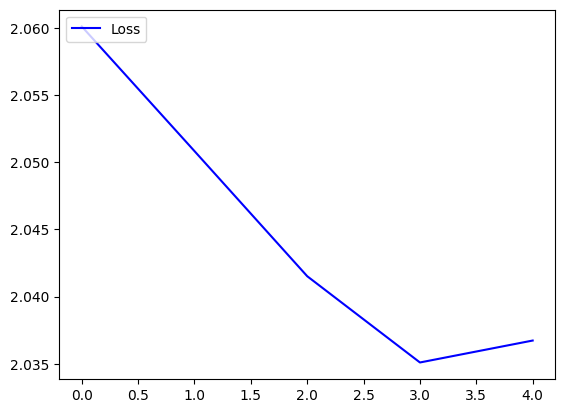

In [25]:
import matplotlib.pyplot as plt
# https://stackabuse.com/matplotlib-plot-multiple-line-plots-same-and-different-scales/
fig, ax = plt.subplots()
ax.plot(loss_append, color = 'blue', label = 'Loss')
ax.legend(loc = 'upper left')
plt.show()

## Illustration of the results
Precision, recall, and F1 score stagger at the beginning but end up stabilizing by the end. Most of these results is because the model predicted '0' for the class

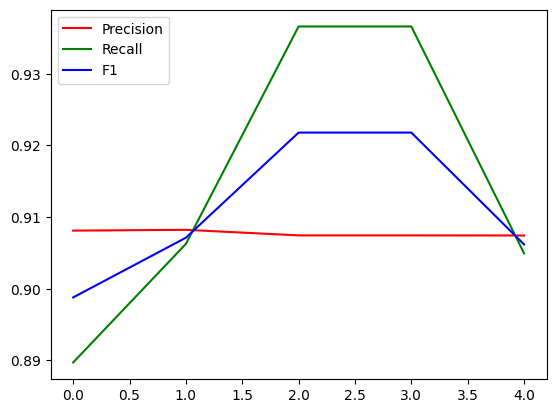

In [26]:
fig, ax = plt.subplots()
ax.plot(p_append, color = 'red', label = 'Precision')
ax.plot(r_append, color = 'green', label = 'Recall')
ax.plot(f_append, color = 'blue', label = 'F1')
ax.legend(loc = 'upper left')
plt.show()

In [27]:
p, r, f, list_pred, list_true = utils.eval_model(gru_rnn, val_loader,True)
print(p)
print(r)
print(f)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pred: [tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), ten

## Illustration of the results
Here we see the results of the evaluation and how many times '0' was predicted, which is almost the majority of classes. However, '0' is not the only class predicted, or the predicted value would exceed 8,000.

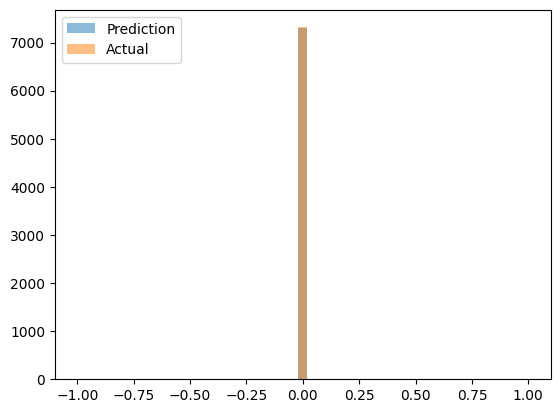

In [28]:
import random
import numpy
from matplotlib import pyplot
bins = numpy.linspace(-1,1)
pyplot.hist(list_pred, bins, alpha=0.5, label='Prediction')
pyplot.hist(list_true, bins, alpha=0.5, label='Actual')
pyplot.legend(loc='upper left')
pyplot.show()

In [29]:
n_epochs = 5
optimizer = torch.optim.Adam(lstm_rnn.parameters(),lr=0.003)
loss_append, p_append, r_append, f_append = utils.train(lstm_rnn, train_loader, val_loader, n_epochs, optimizer, criterion)

Epoch: 1 	 Training Loss: 2.046716


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9076969250553457
0.9526041666666667
0.9296085206054948
Epoch: 1 	 Validation p: 0.91, r:0.95, f: 0.93
Epoch: 2 	 Training Loss: 2.035216


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9076969250553457
0.9526041666666667
0.9296085206054948
Epoch: 2 	 Validation p: 0.91, r:0.95, f: 0.93
Epoch: 3 	 Training Loss: 2.031234


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9077027893066406
0.952734375
0.9296735909681938
Epoch: 3 	 Validation p: 0.91, r:0.95, f: 0.93
Epoch: 4 	 Training Loss: 2.031256


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9077027893066406
0.952734375
0.9296735909681938
Epoch: 4 	 Validation p: 0.91, r:0.95, f: 0.93
Epoch: 5 	 Training Loss: 2.032153
0.908087158203125
0.9373697916666667
0.9224491196328891
Epoch: 5 	 Validation p: 0.91, r:0.94, f: 0.92


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
torch.save(lstm_rnn.state_dict(), "drive/My Drive/DL4H Final/LSTM_Final.pkl")

## Illustration of the results
We see similar results for LSTM

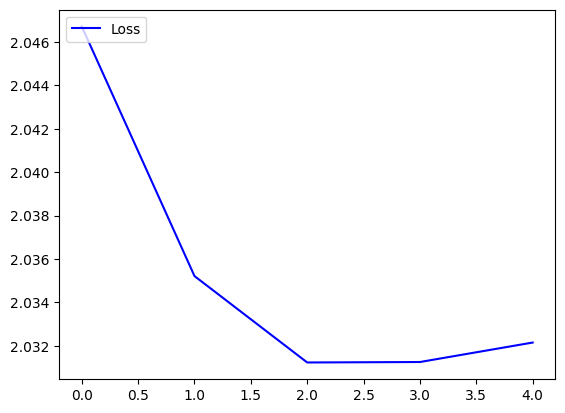

In [31]:
fig, ax = plt.subplots()
ax.plot(loss_append, color = 'blue', label = 'Loss')
ax.legend(loc = 'upper left')
plt.show()

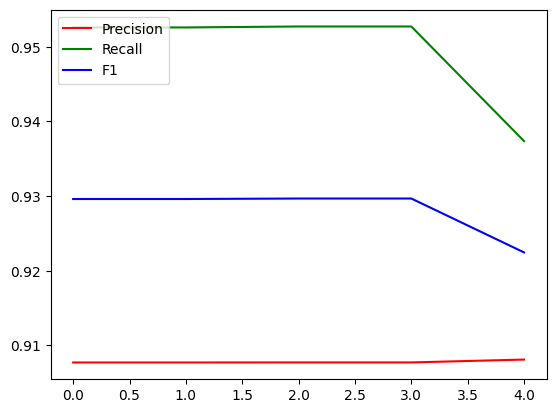

In [32]:
fig, ax = plt.subplots()
ax.plot(p_append, color = 'red', label = 'Precision')
ax.plot(r_append, color = 'green', label = 'Recall')
ax.plot(f_append, color = 'blue', label = 'F1')
ax.legend(loc = 'upper left')
plt.show()

In [33]:
p, r, f, list_pred, list_true = utils.eval_model(lstm_rnn, val_loader,True)
print(p)
print(r)
print(f)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pred: [tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), ten

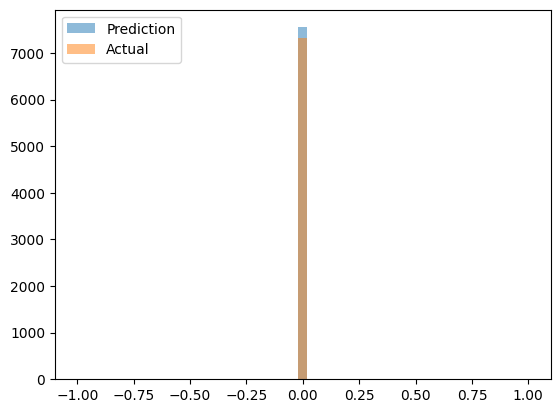

In [34]:
bins = numpy.linspace(-1,1)
pyplot.hist(list_pred, bins, alpha=0.5, label='Prediction')
pyplot.hist(list_true, bins, alpha=0.5, label='Actual')
pyplot.legend(loc='upper left')
pyplot.show()

## References
Finneas Catling, Georgios P Spithourakis, and Sebastian
Riedel. 2018. Towards automated clinical coding.
International journal of medical informatics, 120:50–
61.

Pages 54, 56. Results based on page 56, Table 1.